In [12]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra
using Printf
using ForwardDiff
using JuMP
using COSMO
using ECOS
using Random; 

  Activating environment at `~/SSD/Code/TinyMPC/julia/cone_simple/Project.toml`


In [13]:
# -------------------THIS IS ALL ALTRO-------------------------------
# This enables goal equality constraints, state and input ineq constraints.

function stage_cost(p::NamedTuple,x,u,k)
    dx = x - p.Xref[k]
    du = u - p.Uref[k]
    return 0.5*dx'*p.Q*dx + 0.5*du'*p.R*du
end
function term_cost(p::NamedTuple,x)
    dx = x - p.Xref[p.N]
    return 0.5*dx'*p.Qf*dx
end
function stage_cost_expansion(p::NamedTuple,k)
    dx = - p.Xref[k]
    du = - p.Uref[k]
    return p.Q, p.Q*dx, p.R, p.R*du  # Hessian and gradient
end
function term_cost_expansion(p::NamedTuple)
    dx = - p.Xref[p.N]
    return p.Qf, p.Qf*dx
end
function conic_cost_expansion(p::NamedTuple, u, λc, ρ, k)
    λhat = λc # already updated
    ∇c = cone_u_jac(p, u)
    G = -∇c'*∇projection(λhat)*projection(λhat)
    # H = ∇c'*∇projection(λhat)'*∇projection(λhat)*∇c/ρ
    H = ∇c'*(∇projection(λhat)'*∇projection(λhat) + ∇²projection(λhat, projection(λhat)))*∇c*ρ
    return (G - H*u), H
end
function backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
    """iLQR backward pass with AL. This !function update its parameters
    """
    N = params.N
    ΔJ = 0.0    # expected cost reduction

    # terminal cost expansion
    P[N], p[N] = term_cost_expansion(params) 
    
    if (params.ncx > 0)
        # add AL terms for the state constraint at the final time step
        hxv = ineq_con_x(params,X[N])  # h(x) violation  
        mask = eval_mask(μx[N],hxv)
        ∇hx = ineq_con_x_jac(params,X[N])
        # add these into the cost-to-go p and P
        μx[N] = μx[N] - ρ*(mask * [params.x_max;-params.x_min])
        p[N] += ∇hx'*μx[N]  # multiplier term (1st)
        P[N] += ρ*∇hx'*mask*∇hx                # penalty term (2nd)
    end
    
    if (params.ncg > 0)
        # add AL terms for goal constraint 
        ∇hx = diagm(ones(params.nx))
        # add these into the CTG p and P (equality active)
        λ = λ - ρ*params.Xref[N]
        p[N] += ∇hx'*λ 
        P[N] += ρ*∇hx'∇hx
    end
    
    # iterate from N-1 to 1 backwards
    for k = (N-1):(-1):1
        # dynamics jacobians (basically linear but still computed)
        A = ForwardDiff.jacobian(_x -> discrete_dynamics(params,_x,U[k],k),X[k])
        B = ForwardDiff.jacobian(_u -> discrete_dynamics(params,X[k],_u,k),U[k])
        f = discrete_dynamics(params,zeros(params.nx),zeros(params.nu),k)

        Sxx,Sx,Suu,Su = stage_cost_expansion(params,k)
        
        # one-step cost expansion: Q, Q*dx, R, R*du
        Sx += A' * (P[k+1]*f + p[k+1]) 
        Su += B' * (P[k+1]*f + p[k+1]) 
        Sxx += A' * P[k+1] * A
        Suu += B' * (P[k+1] + reg*I) * B                                     
        Sux = B' * P[k+1] *A  
        if (params.ncu > 0)
            # control constraints
            huv = ineq_con_u(params,U[k])  # calculate h(u) constraint
            mask = eval_mask(μ[k],huv)  # choose active
            ∇hu = ineq_con_u_jac(params,U[k])
            μ[k] .= μ[k] - ρ*(mask * [params.u_max;-params.u_min])
            Su  += ∇hu'*μ[k] # add to cost
            Suu += ρ*∇hu'*mask*∇hu
        end
        if (params.ncx > 0)
            # state constraints
            hxv = ineq_con_x(params,X[k])
            mask = eval_mask(μx[k],hxv)
            ∇hx = ineq_con_x_jac(params,X[k])
            μx[k] .= μx[k] - ρ*(mask * [params.x_max;-params.x_min])
            Sx  += ∇hx'*μx[k]
            Sxx += ρ*∇hx'*mask*∇hx
        end
        if (params.ncu_cone > 0)
            # conic constraints
            Qu, Quu = conic_cost_expansion(params, U[k], λc[k], ρ*cone_scale, k)
            # display(Quu)
            Su += Qu
            Suu += Quu
        end
        
        # Calculate Gains
        # for i = 1:10
        #     if isposdef(Suu) == 0
        #         Suu += reg*I
        #     end
        # end
        F = cholesky(Symmetric(Suu))
        d[k] = Suu\Su
        K[k] = Suu\Sux

        # Cost-to-go Recurrence (PSD stabilizing version, last term)
        P[k] = Sxx + K[k]'*Suu*K[k] - K[k]'*Sux - Sux'*K[k]
        p[k] = Sx + K[k]'*Suu*d[k] - K[k]'*Su - Sux'*d[k]
        ΔJ += Su'*d[k]
    end

    return ΔJ  # but also change params
end
function forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ)
    """iLQR forward pass and line-search
    This !function update its parameters
    """
    N = params.N
        # Forward Rollout
        for k = 1:(N-1)
            Un[k] = - d[k] - K[k]*Xn[k] 
            Xn[k+1] = discrete_dynamics(params,Xn[k],Un[k],k)
        end
    X .= Xn
    U .= Un
    return 0, 0
end
function eval_mask(μv,huv)  
    # Extract active inequality constraints
    # active set mask
    mask = Diagonal(zeros(length(huv)))
    for i = 1:length(huv)
        mask[i,i] = (μv[i] > 0 || huv[i] > 0)
    end
    mask
end
function mpc(params,X,U,P,p,K,d,Xn,Un;atol=1e-3,max_iters=250,verbose=true,ρ=1,ρmax=1e8,ϕ=10)

    # first check the sizes of everything
    # @assert length(X) == params.N
    # @assert length(U) == params.N-1
    # @assert length(X[1]) == params.nx
    # @assert length(U[1]) == params.nu

    # initial rollout
    N = params.N
    for i = 1:N-1
        X[i+1] = discrete_dynamics(params,X[i],U[i],i)
    end

    reg_min = 0*1e-8
    reg = reg_min

    μ = params.μ   # input constraints
    μx = params.μx    # state constraints
    λ = params.λ    # goal constraint
    λc = params.λc   # goal constraint
    
    # Inner loop to solve unconstrained problem (Riccati)
    for iter = 1:max_iters        
        J = 0.0
        ΔJ = 0.0
        α = 1.0
        for i = 1:1
            ΔJ = backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
            J, α = forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ)
        end

        if verbose
            if rem(iter-1,10)==0
                @printf "iter     J           ΔJ        |d|         α        reg         ρ\n"
                @printf "---------------------------------------------------------------------\n"
            end
            @printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f   %9.2e   %9.2e\n",
              iter, J, ΔJ, 0, α, reg, ρ)
        end
        # update multipliers and check constraint violation, max of all
        convio = 0.0  
        
        if (params.ncu > 0)
            # control constraints (inequality)
            for k = 1:N-1
                huv = ineq_con_u(params,U[k])
                mask = eval_mask(μ[k],huv)
                # update dual?
                convio = max(convio,norm(huv + abs.(huv),Inf))
                # μ[k] .= max.(0,μ[k] - ρ*(mask * [params.u_max;-params.u_min]))
            end
        end
        if (params.ncx > 0)
            # state constraints (inequality)
            for k = 1:N
                hxv = ineq_con_x(params,X[k])
                mask = eval_mask(μx[k],hxv)
                # update dual
                convio = max(convio,norm(hxv + abs.(hxv),Inf))
                # @show μx[k] .= max.(0,μx[k] - ρ*(mask * [params.x_max;-params.x_min]))                
            end
        end
        if (params.ncu_cone > 0)
            # conic constraints 
            if verbose
                print("update cone\n")
            end            
            for k = 1:N-1
                # update dual
                Uc = cone_u(params, U[k])
                huc = norm(Uc[1:2]) - Uc[3]
                convio = max(convio, norm(huc + abs.(huc),Inf))
                λc[k] = projection(λc[k] - Uc*cone_scale*ρ)
                # display(λc[k])
            end
        end
        if (params.ncg > 0)
            # goal constraint (equality)
            hxv = X[N] - params.Xref[N]
            # λ .-= ρ*params.Xref[N]
            convio = max(convio, norm(hxv,Inf))
        end
        
        ρ *= ϕ  # update penalty
        
        if verbose
            @show convio
        end
        if convio < atol  # if terminal condition with contraint violation
            # print("Our solver says SUCCESS\n") # @info "success!"
            return U[1]
        end
        if ρ > ρmax
            print("Our solver reachs MAX PENALTY\n")
            return U[1]
        end
    end
    print("Our solver says INFEASIBLE and MAX ITER\n")
    return U[1]
end
#----------------------ALTRO DONE --------------------------

mpc (generic function with 1 method)

In [14]:
# -------------------THIS IS ALL ALTRO-------------------------------
# This enables goal equality constraints, state and input ineq constraints.
function stage_cost(p::NamedTuple,x,u,k)
  dx = x - p.Xref[k]
  du = u - p.Uref[k]
  return 0.5*dx'*p.Q*dx + 0.5*du'*p.R*du
end
function term_cost(p::NamedTuple,x)
  dx = x - p.Xref[p.N]
  return 0.5*dx'*p.Qf*dx
end
function stage_cost_expansion(p::NamedTuple,k)
  dx = - p.Xref[k]
  du = - p.Uref[k]
  return p.Q, p.Q*dx, p.R, p.R*du  # Hessian and gradient
end
function term_cost_expansion(p::NamedTuple)
  dx = - p.Xref[p.N]
  return p.Qf, p.Qf*dx
end
function conic_cost_expansion(p::NamedTuple, u, λc, ρ, k)
    Uc = cone_u(params, u)
    λhat = 1*λc # already updated
    # λhat = 1*projection(λc - Uc*cone_scale*ρ)
    ∇c = cone_u_jac(p, u)
    G = -∇c'*∇projection(λhat)*projection(λhat)
    # H = ∇c'*∇projection(λhat)'*∇projection(λhat)*∇c*ρ
    H = ∇c'*(∇projection(λhat)'*∇projection(λhat) + ∇²projection(λhat, projection(λhat)))*∇c*ρ
    return (G - H*u), H
end
function backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
  """iLQR backward pass with AL. This !function update its parameters
  """
  N = params.N
  ΔJ = 0.0    # expected cost reduction

  # terminal cost expansion
  P[N], p[N] = term_cost_expansion(params) 
  
  if (params.ncx > 0)
      # # add AL terms for the state constraint at the final time step
      hxv = ineq_con_x(params,X[N])  # h(x) violation  
      mask = eval_mask(μx[N],hxv)
      ∇hx = ineq_con_x_jac(params,X[N])
      # add these into the cost-to-go p and P
      p[N]  += ∇hx'*(μx[N] - ρ*(mask * [params.x_max;-params.x_min]))  # multiplier term (1st)
      P[N]  += ρ*∇hx'*mask*∇hx                # penalty term (2nd)
  end
  
  if (params.ncg > 0)
      # add AL terms for goal constraint 
      ∇hx = diagm(ones(params.nx))
      # add these into the CTG p and P (equality active)
      p[N]  += ∇hx'*(λ - ρ*params.Xref[N])   
      P[N]  += ρ*∇hx'∇hx
  end
  
  # iterate from N-1 to 1 backwards
  for k = (N-1):(-1):1
      # dynamics jacobians (linearization about previous iterate)
      A = ForwardDiff.jacobian(_x -> discrete_dynamics(params,_x,U[k],k),X[k])
      B = ForwardDiff.jacobian(_u -> discrete_dynamics(params,X[k],_u,k),U[k])
      f = discrete_dynamics(params,zeros(params.nx),zeros(params.nu),k)
      Sxx,Sx,Suu,Su = stage_cost_expansion(params,k)
      
      # one-step cost expansion: Q, Q*dx, R, R*du
      Sx += A' * (P[k+1]*f + p[k+1]) 
      Su += B' * (P[k+1]*f + p[k+1]) 
      Sxx += A'*(P[k+1])*A
      Suu += B'*(P[k+1] + reg*I)*B                                     
      Sux = B'*(P[k+1])*A  
      if (params.ncu > 0)
          # control constraints
          huv = ineq_con_u(params,U[k])  # calculate h(u) constraint
          mask = eval_mask(μ[k],huv)  # choose active
          ∇hu = ineq_con_u_jac(params,U[k])
          Su  += ∇hu'*(μ[k] - ρ*(mask * [params.u_max;-params.u_min])) # add to cost
          Suu += ρ*∇hu'*mask*∇hu
      end
      if (params.ncx > 0)
          # state constraints
          hxv = ineq_con_x(params,X[k])
          mask = eval_mask(μx[k],hxv)
          ∇hx = ineq_con_x_jac(params,X[k])
          Sx  += ∇hx'*(μx[k] - ρ*(mask * [params.x_max;-params.x_min]))
          Sxx += ρ*∇hx'*mask*∇hx
      end
      if (params.ncu_cone > 0)
          # conic constraints
          Qu, Quu = conic_cost_expansion(params, U[k], λc[k], ρ*cone_scale, k)
          # display(Quu)
          Su += Qu
          Suu += Quu
      end
      
      # Calculate Gains
      # if isposdef(Suu) == 0
      #     for i = 1:10
      #         Suu += reg*I
      #         if isposdef(Suu) == 1
      #             break
      #         end
      #     end
      # end
          
      F = cholesky(Symmetric(Suu))
      d[k] = F\Su
      K[k] = F\Sux

      # Cost-to-go Recurrence (PSD stabilizing version, last term)
      P[k] = Sxx + K[k]'*Suu*K[k] - K[k]'*Sux - Sux'*K[k]
      p[k] = Sx + K[k]'*Suu*d[k] - K[k]'*Su - Sux'*d[k]
      ΔJ += Su'*d[k]
  end

  return ΔJ  # but also change params
end
function trajectory_AL_cost(params,X,U,μ,μx,ρ,λ,λc)
    N = params.N
    J = 0.0
    for k = 1:N-1
        J += stage_cost(params,X[k],U[k],k)
        if params.ncu > 0
            # AL terms for ineq_con_u
            huv = ineq_con_u(params,U[k])
            mask = eval_mask(μ[k],huv)
            J += dot(μ[k],huv) + 0.5*ρ*huv'*mask*huv
        end
        if params.ncx > 0
            # AL terms for ineq_con_x
            hxv = ineq_con_x(params,X[k])
            mask = eval_mask(μx[k],hxv)
            J += dot(μx[k],hxv) + 0.5*ρ*hxv'*mask*hxv
        end
        if params.ncu_cone > 0
            Uc = cone_u(params, U[k])
            λhat = 1*projection(λc[k] - Uc*cone_scale*ρ)
            J += (0.5/ρ)*(λhat'*λhat - λc[k]'*λc[k])
        end

    end
    if params.ncx > 0
    # AL terms for state constraint at last time step
    J += term_cost(params,X[N])
    hxv = ineq_con_x(params,X[params.N])
    mask = eval_mask(μx[params.N],hxv)
    J += dot(μx[params.N],hxv) + 0.5*ρ*hxv'*mask*hxv
    end
    if params.ncg > 0
    # AL terms for goal constraint
    hxv = X[N] - params.Xref[N]
    J += dot(λ,hxv) + 0.5*ρ*hxv'*hxv
    end
    return J
end
function forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ,λc; max_linesearch_iters=20)
  """iLQR forward pass and line-search
  This !function update its parameters
  """
  N = params.N
  # Forward Rollout
  J = trajectory_AL_cost(params,X,U,μ,μx,ρ,λ,λc)
  for k = 1:(N-1)
      Un[k] = - d[k] - K[k]*Xn[k] 
      Xn[k+1] = discrete_dynamics(params,Xn[k],Un[k],k)
  end
  Jn = trajectory_AL_cost(params,Xn,Un,μ,μx,ρ,λ,λc)
  ΔJ = J - Jn
  X .= Xn
  U .= Un
  return Jn, ΔJ
end
function eval_mask(μv,huv)  
  # Extract active inequality constraints
  # active set mask
  mask = Diagonal(zeros(length(huv)))
  for i = 1:length(huv)
      mask[i,i] = (μv[i] > 0 || huv[i] > 0)
  end
  mask
end
function mpc(params,X,U,P,p,K,d,Xn,Un;atol=1e-3,max_iters=250,verbose=true,ρ=1,ρ_max=1e8,ϕ=10)
  
  # first check the sizes of everything
  # @assert length(X) == params.N
  # @assert length(U) == params.N-1
  # @assert length(X[1]) == params.nx
  # @assert length(U[1]) == params.nu

  # initial rollout
  N = params.N
  for i = 1:N-1
      X[i+1] = discrete_dynamics(params,X[i],U[i],i)
  end

  reg_min = 1e-8
  reg = reg_min

  μ = params.μ
  μx = params.μx
  λ = params.λ
  λc = params.λc
  
  # Inner loop to solve unconstrained problem (Riccati)
  for iter = 1:max_iters      
      J = 0.0
      ΔJ = 0.0
      α = 1.0
      for i = 1:max_inner_iters
          ΔJ = backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
          J, ΔJ = forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ,λc)
          @show ΔJ
          if 0.0 <= ΔJ <= 1.0 
            break
          end
      end

      if verbose
          if rem(iter-1,10)==0
              @printf "iter     J           ΔJ        |d|         α        reg         ρ\n"
              @printf "---------------------------------------------------------------------\n"
          end
          @printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f   %9.2e   %9.2e\n",
            iter, J, ΔJ, 0, α, reg, ρ)
      end
      # update multipliers and check constraint violation, max of all
      convio = 0  
      
      if (params.ncu > 0)
          # control constraints (inequality)
          for k = 1:N-1
              huv = ineq_con_u(params,U[k])
              mask = eval_mask(μ[k],huv)
              # update dual
              convio = max(convio,norm(huv + abs.(huv),Inf))
              μ[k] .= max.(0,μ[k] - ρ*(mask * [params.u_max;-params.u_min]))
          end
      end
      if (params.ncx > 0)
          # state constraints (inequality)
          for k = 1:N
              hxv = ineq_con_x(params,X[k])
              mask = eval_mask(μx[k],hxv)
              # update dual
              convio = max(convio,norm(hxv + abs.(hxv),Inf))
              μx[k] .= max.(0,μx[k] - ρ*(mask * [params.x_max;-params.x_min]))                
          end
      end
      if (params.ncu_cone > 0)
          # conic constraints 
          if verbose
              print("update cone\n")
          end            
          for k = 1:N-1
              # update dual
              Uc = cone_u(params, U[k])
              huc = norm(Uc[1:2]) - Uc[3]
              convio = max(convio, norm(huc + abs.(huc),Inf))
              λc[k] .= projection(λc[k] - Uc*cone_scale*ρ)
              # display(λc[k])
          end
      end
      if (params.ncg > 0)
          # goal constraint (equality)
          hxv = X[N] - params.Xref[N]
          λ .-= ρ*params.Xref[N]
          convio = max(convio, norm(hxv,Inf))
      end
      
      ρ *= ϕ  # update penalty
      
      if verbose
          @show convio
      end
      if convio < atol  # if terminal condition with contraint violation
          # print("Our solver says SUCCESS\n") # @info "success!"
          return U[1]
      end
      if ρ > ρ_max
          print("Our solver reachs MAX PENALTY\n")
          return U[1]
      end
  end
  print("Our solver says INFEASIBLE and MAX ITER\n")
  return U[1]
end

affine = 1  # SOLVE AFFINE DYNAMICS

1

In [21]:
# =============================
# Example problem formulation and solve
# =============================

# ---------------------THIS IS WHAT YOU NEED TO INPUT--------
A = [1.0 0.0 0.0 0.05 0.0 0.0; 
0.0 1.0 0.0 0.0 0.05 0.0; 
0.0 0.0 1.0 0.0 0.0 0.05; 
0.0 0.0 0.0 1.0 0.0 0.0; 
0.0 0.0 0.0 0.0 1.0 0.0; 
0.0 0.0 0.0 0.0 0.0 1.0]
B = [0.000125 0.0 0.0; 
0.0 0.000125 0.0;
0.0 0.0 0.000125; 
0.005 0.0 0.0; 
0.0 0.005 0.0; 
0.0 0.0 0.005]
f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]*affine
function discrete_dynamics(p::NamedTuple,x,u,k)
    A = [1.0 0.0 0.0 0.05 0.0 0.0; 
        0.0 1.0 0.0 0.0 0.05 0.0; 
        0.0 0.0 1.0 0.0 0.0 0.05; 
        0.0 0.0 0.0 1.0 0.0 0.0; 
        0.0 0.0 0.0 0.0 1.0 0.0; 
        0.0 0.0 0.0 0.0 0.0 1.0]
    B = [0.000125 0.0 0.0; 
        0.0 0.000125 0.0;
        0.0 0.0 0.000125; 
        0.005 0.0 0.0; 
        0.0 0.005 0.0; 
        0.0 0.0 0.005]
    f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
    return A*x + B*u + f*affine
end
function ineq_con_x(p,x)
    [x-p.x_max;-x + p.x_min]
end
function ineq_con_u(p,u)
    [u-p.u_max;-u + p.u_min]
end
function cone_u(p, u)
    [p.A_cone*u;p.c_cone'*u]
end
function cone_u_jac(p, u)
    J = zeros(p.nu, p.nu)
    J[1:end-1,1:end] .= p.A_cone
    J[end,1:end] .= p.c_cone
    return J
end
function ineq_con_u_jac(params,u)
    ForwardDiff.jacobian(_u -> ineq_con_u(params,_u), u)
end
function ineq_con_x_jac(p,x)
    ForwardDiff.jacobian(_x -> ineq_con_x(p,_x),x)
end
function projection(x)
    # assumes x is stacked [v; s] such that ||v||₂ ≤ s
    n = length(x)
    v = view(x, 1:n-1)
    s = x[end]
    a = norm(v)
    if a <= -s          # below the cone 
        return zero(x) 
    elseif a <= s       # in the cone
        return x
    elseif a >= abs(s)  # outside the cone 
        return 0.5 * (1 + s/a) * [v; a]
    else
        throw(ErrorException("Invalid second-order cone projection"))  # Nan
    end
end
function ∇projection(x)
    n = length(x)
    J = zeros(eltype(x),n,n)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s
        return J  # zeros
    elseif a <= s
        J .= I(n)  
        return J  # identity
    elseif a >= abs(s)
        c = 0.5 * (1 + s/a)

        # dvdv ok!
        for i = 1:n-1, j = 1:n-1
            J[i,j] = -0.5*s/a^3 * v[i] * v[j]
            if i == j
                J[i,j] += c
            end
        end

        # dvds ok!
        for i = 1:n-1
            J[i,n] = 0.5 * v[i] / a
        end

        # dsdv ok!
        for i = 1:n-1
            J[n,i] = ((-0.5*s/a^2) + c/a) * v[i]
        end
        J[n,n] = 0.5  # ok
        return J
    else
        error("Invalid second-order cone projection.")
    end
    return J
end
function ∇projection(x) 
    n = length(x)
    v = view(x, 1:n-1)
    s = x[end]
    a = norm(v)
    J = zeros(n, n)
    if a <= -s                               # below cone
        J .*= 0
    elseif a <= s                            # in cone
        J .*= 0
        for i = 1:n
            J[i,i] = 1.0
        end
    elseif a >= abs(s)                       # outside cone
        # scalar
        c = 0.5 * (1 + s/a)   

        # dvdv = dbdv * v' + c * oneunit(SMatrix{n-1,n-1,T})
        for i = 1:n-1, j = 1:n-1
            J[i,j] = -0.5*s/a^3 * v[i] * v[j]
            if i == j
                J[i,j] += c
            end
        end

        # dvds
        for i = 1:n-1
            J[i,n] = 0.5 * v[i] / a
        end

        # ds
        for i = 1:n-1
            J[n,i] = ((-0.5*s/a^2) + c/a) * v[i]
        end
        J[n,n] = 0.5 
    else
        throw(ErrorException("Invalid second-order cone projection"))
    end
    return J
end
function ∇²projection(x, b)
    # x is lamda_bar, b is projection(lambda_bar)
    n = length(x)
    hess = zeros(eltype(x),n,n)
    v = view(x, 1:n-1)
    bv = view(b, 1:n-1)

    # @assert size(hess) == (n+1,n+1)
    s = x[end]
    bs = b[end]
    a =  norm(v)
    vbv = dot(v,bv)

    if a <= -s
        return hess .= 0
    elseif a <= s
        return hess .= 0
    elseif a > abs(s)
        # Original equations from chain rule
        # dvdv = -s/norm(v)^2/norm(v)*(I - (v*v')/(v'v))*bv*v' + 
        #     s/norm(v)*((v*(v'bv))/(v'v)^2 * 2v' - (I*(v'bv) + v*bv')/(v'v)) + 
        #     bs/norm(v)*(I - (v*v')/(v'v))
        # dvds = 1/norm(v)*(I - (v*v')/(v'v))*bv;
        # # display(dvds)
        # # display(dvdv)
        # hess[1:n-1,1:n-1] .= dvdv*0.5
        # hess[1:n-1,n] .= dvds*0.5
        # hess[n:n,1:n-1] .= 0.5*dvds'
        # hess[n,n] = 0
        # return hess

        # The following is just an unrolled version of the above
        n = n - 1
        dvdv = view(hess, 1:n, 1:n)
        dvds = view(hess, 1:n, n+1)
        dsdv = view(hess, n+1, 1:n)
        @inbounds for i = 1:n
            hi = 0
            @inbounds for j = 1:n
                Hij = -v[i]*v[j] / a^2
                if i == j
                    Hij += 1
                end
                hi += Hij * bv[j]
            end
            dvds[i] = hi / 2a
            dsdv[i] = dvds[i]
            @inbounds for j = 1:i
                vij = v[i] * v[j]
                H1 = hi * v[j] * (-s/a^3)
                H2 = vij * (2*vbv) / a^4 - v[i] * bv[j] / a^2
                H3 = -vij / a^2
                if i == j
                    H2 -= vbv / a^2
                    H3 += 1
                end
                H2 *= s/a
                H3 *= bs/a
                dvdv[i,j] = (H1 + H2 + H3) / 2
                dvdv[j,i] = dvdv[i,j]
            end
        end
        hess[end,end] = 0
        return hess
    else
        throw(ErrorException("Invalid second-order cone projection"))
    end
end

∇²projection (generic function with 1 method)

ΔJ = 4.03904008243794e7
ΔJ = 0.0
iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    1.262e+06   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e-02
convio = 25.70540363407883
ΔJ = -59.816445698263124
ΔJ = 0.0
  2    1.262e+06   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e-01
convio = 25.687408982081863
ΔJ = -589.9369846205227
ΔJ = 0.0
  3    1.263e+06   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+00
convio = 25.50869784510975
ΔJ = -5143.123241520021
ΔJ = 0.0
  4    1.274e+06   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+01
convio = 23.837171754411823
ΔJ = -12109.054997113533
ΔJ = 0.0
  5    1.336e+06   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+02
convio = 19.76904837417863
ΔJ = 141759.79754503164
ΔJ = 0.0
  6    1.458e+06   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+03
convio = 9.73699998035871
ΔJ = 358297.3849114883
ΔJ = 0.0
  7    1.540e+06   0.00e+00   0.00e+00  1.0

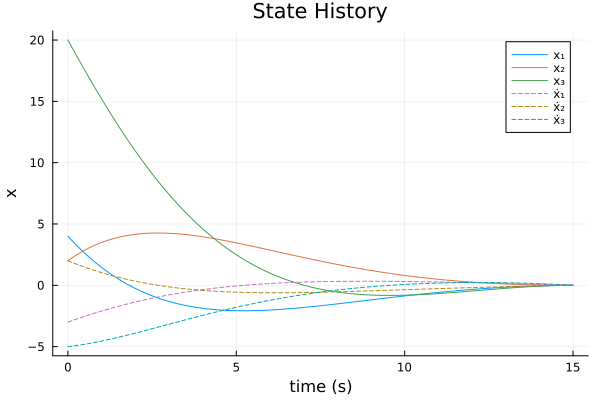

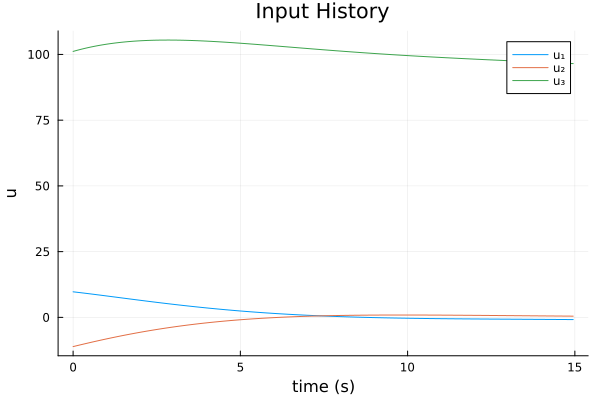

In [23]:
# Let's solve
# include("mpc_JuMP.jl")
nx = 6
nu = 3
N = 301
dt = 0.05
t_vec = dt*(0:N-1)
x0 = [4, 2, 20, -3, 2, -5.0]
xg = [0,0,0,0,0,0.0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

Q = 10e-1*I(nx)
R = 1e-0*I(nu)
Qf = 100*I(nx)

# ground_level = 0.0
gravity = [0; 0; -9.81]
mass = 10.0
# ωPlanet = [0.0; 0.0; 0.0]
perWeightMax = 2.0
θ_thrust_max = 5.0  # deg
# θ_glideslope = 60.0 # deg
# glide_recover_k = 8

A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]
u_bnd = mass * abs(gravity[3]) * perWeightMax
u_min = -10.0*ones(nu)
u_max =  105.0*ones(nu)

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

max_inner_iters = 10  # MAX RICCATI SOLVING ITERATION
ncx = 2*nx*0
ncu = 2*nu*0
ncg = 1
ncu_cone = nu*0; 
cone_scale = 1e0  # very fragile for each problem

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone,
    c_cone = c_cone,
    N = N,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [zeros(nu) for k = 1:N-1]
# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

include("mpc_JuMP.jl")
optimizers = (
    JuMP.optimizer_with_attributes(COSMO.Optimizer,
        "verbose"=>false,
        "eps_abs"=>1e-4,
        "eps_rel"=>1e-4,
        "rho"=>1e-2,
        "scaling"=>0,
        "alpha"=>1.0),
    JuMP.optimizer_with_attributes(ECOS.Optimizer, 
        "verbose"=>false,
        "feastol"=>1e-4,
        "abstol"=>1e-4,
        "reltol"=>1e-4)) 
# trajopt_JuMP1(optimizers[1], params, Xn, Un, A, B, f; warm_start=false)
u_ = mpc(params,X,U,P,p,K,d,Xn,Un; atol=1e-4, max_iters=20, verbose = true, ρ = 1e-2, ρ_max=1e10, ϕ=10.0);

function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
using Plots
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))

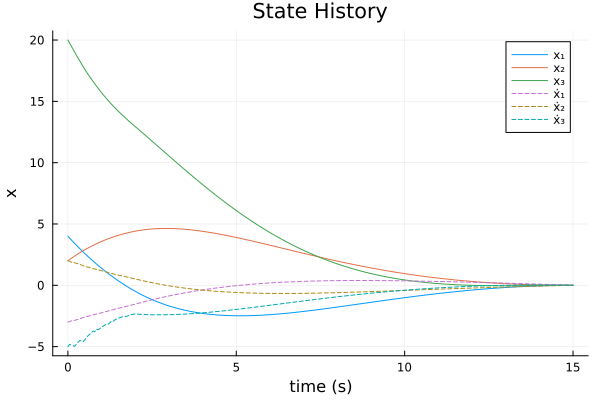

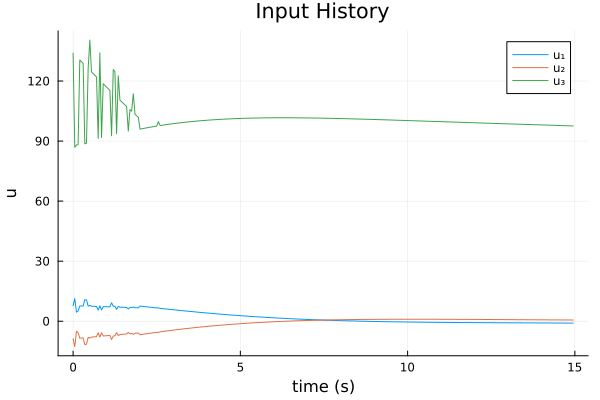

In [17]:
Xtest = [deepcopy(x0) for i = 1:N]
for k = 1:N-1
  Xtest[k+1] = discrete_dynamics(params, Xtest[k], Un[k], k)
end
Xsim_m = mat_from_vec(Xtest)
Usim_m = mat_from_vec(Un)
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))

In [18]:
# ---------------------DOUBLE INTEGRATOR--------
function discrete_dynamics(p::NamedTuple,x,u,k)
    # RK4
    A = [1.0  0.0  0.1  0.0;
         0.0  1.0  0.0  0.1;
         0.0  0.0  1.0  0.0;
         0.0  0.0  0.0  1.0]
    B = [0.005  0.0;
         0.0    0.005;
         0.1    0.0;
         0.0    0.1]
    return A*x + B*u
end
function ineq_con_x(p,x)
    [x-p.x_max;-x + p.x_min]
end
function ineq_con_u(p,u)
    [u-p.u_max;-u + p.u_min]
end
function ineq_con_u_jac(params,u)
    ForwardDiff.jacobian(_u -> ineq_con_u(params,_u), u)
end
function ineq_con_x_jac(p,x)
    ForwardDiff.jacobian(_x -> ineq_con_x(p,_x),x)
end

# here is the script
nx = 4
nu = 2
N = 30
dt = 0.1
t_vec = dt*(0:N-1)
x0 = [0,0,0,0.]
xg = [1,1.,0,0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]
Q = 1e-2*I(nx)
R = 1e-1*I(nu)
Qf = 1*I(nx)

u_min = -2*ones(nu)
u_max =  2*ones(nu)

# state is x y v θ
x_min = -2*ones(nx)
x_max =  2*ones(nx)

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 1
ncu_cone = 0

μ = [zeros(ncu) for i = 1:N-1]   # input constraints
μx = [zeros(ncx) for i = 1:N]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone,
    c_cone = c_cone,
    N = N,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [.01*randn(nu) for i = 1:N-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain
u_ = mpc(params,X,U,P,p,K,d,Xn,Un; atol=1e-4, max_iters = 20, verbose = true, ρ = 1e2, ρmax = 1e8, ϕ = 10.0);

Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
using Plots
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "ẋ₁" "ẋ₂" ],linestyle=[:solid :solid :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))

LoadError: MethodError: no method matching mpc(::NamedTuple{(:nx, :nu, :ncx, :ncu, :ncg, :ncu_cone, :μ, :μx, :λ, :λc, :A_cone, :c_cone, :N, :Q, :R, :Qf, :u_min, :u_max, :x_min, :x_max, :Xref, :Uref, :dt, :mc, :mp, :l, :g), Tuple{Int64, Int64, Int64, Int64, Int64, Int64, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Vector{Float64}}, Matrix{Int64}, Vector{Float64}, Int64, Diagonal{Float64, Vector{Float64}}, Diagonal{Float64, Vector{Float64}}, Diagonal{Int64, Vector{Int64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Vector{Float64}}, Vector{Vector{Float64}}, Float64, Float64, Float64, Float64, Float64}}, ::Vector{Vector{Float64}}, ::Vector{Vector{Float64}}, ::Vector{Matrix{Float64}}, ::Vector{Vector{Float64}}, ::Vector{Matrix{Float64}}, ::Vector{Vector{Float64}}, ::Vector{Vector{Float64}}, ::Vector{Vector{Float64}}; atol=0.0001, max_iters=20, verbose=true, ρ=100.0, ρmax=1.0e8, ϕ=10.0)
[0mClosest candidates are:
[0m  mpc(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any; atol, max_iters, verbose, ρ, ρ_max, ϕ) at In[14]:182[91m got unsupported keyword argument "ρmax"[39m

In [ ]:
Un

In [ ]:
# Enable warm-starting
function trajopt_JuMP1(optimizer, params, X, U, A, B, f; warm_start=true)
  Nh = params.N
  nx = params.nx
  nu = params.nu
  α_max = params.c_cone[3]
  NN = Nh*nx + (Nh-1)*nu
  x0 .= X[1]
  
  inds = reshape(1:(nx+nu)*Nh,nx+nu,Nh)  
  xinds = [z[1:nx] for z in eachcol(inds)]
  uinds = [z[nx+1:end] for z in eachcol(inds)][1:Nh-1]    
  
  model = Model(optimizer)
  
  @variable(model, z[1:NN])  # z is all decision variables (X U)
  if warm_start
      z_ws = zeros(NN,1)
      for j = 1:Nh-1
          z_ws[xinds[j]] .= X[j]
          z_ws[uinds[j]] .= U[j]
      end
      z_ws[xinds[Nh]] .= X[Nh]
      set_start_value.(z, z_ws)
  end
  
  P = zeros(NN, NN)
  q = zeros(NN, 1) 
  # Cost function   
  for j = 1:Nh-1
      P[(j-1)*(nx+nu).+(1:nx),(j-1)*(nx+nu).+(1:nx)], q[(j-1)*(nx+nu).+(1:nx)], 
      P[(j-1)*(nx+nu)+nx.+(1:nu),(j-1)*(nx+nu)+nx.+(1:nu)], q[(j-1)*(nx+nu)+nx.+(1:nu)] = stage_cost_expansion(params, j)
  end    
  P[end-nx+1:end,end-nx+1:end], q[end-nx+1:end] = term_cost_expansion(params)
  @objective(model, Min, 0.5*dot(z,P,z) + dot(q,z))

  # Dynamics Constraints
  for k = 1:Nh-1
      @constraint(model, A*z[xinds[k]] .+ B*z[uinds[k]] .+ f .== z[xinds[k+1]])
  end
  
  # Initial condition 
  @constraint(model, z[xinds[1]] .== x0)
  
#   Thrust angle constraint
  if params.ncu_cone > 0 
    for k = 1:Nh-1
        u1,u2,u3 = z[uinds[k]]
        @constraint(model, [α_max * u3, u1, u2] in JuMP.SecondOrderCone())
    end
  end
  
  # State Constraints
  if params.ncx > 0 
    for k = 1:Nh
      @constraint(model, z[xinds[k]] .<= params.x_max)
      @constraint(model, z[xinds[k]] .>= params.x_min)
    end  
  end

  # Input Constraints
  if params.ncu > 0 
    for k = 1:Nh-1
      @constraint(model, z[uinds[k]] .<= params.u_max)
      @constraint(model, z[uinds[k]] .>= params.u_min)
    end  
  end

  # Goal constraint
  if params.ncg > 0 
      @constraint(model, z[xinds[N]] .== zeros(nx))
  end    

  optimize!(model)   
  termination_status(model) == INFEASIBLE && print("Other solver says INFEASIBLE\n")
  for j = 1:Nh-1
      X[j] .= value.(z[xinds[j]]) 
      U[j] .= value.(z[uinds[j]]) 
  end    
  X[Nh] .= value.(z[xinds[Nh]])
  # display(MOI.get(model, MOI.SolveTimeSec()))
  return X
end

trajopt_JuMP1 (generic function with 1 method)

In [ ]:
@show params.λ'*X[N]
X[N]
# params.μx
convio = 0.0
if params.ncx > 0
  for k = 1:N
    hxv = ineq_con_x(params,X[k])
    mask = eval_mask(μx[k],hxv)
    # update dual
    convio = max(convio,norm(hxv + abs.(hxv),Inf)) 
    @show params.μx[k]'*hxv         
  end
end

(params.λ)' * X[N] = 0.0


For TrajOpt, it needs more tricks to get better results:
- Hessian of the projection => better approximation (done)
- Scaling between conic constraints and other ones (1/rho, Zac did not buy it)
- Solution polishing?

Maybe, we don't care about TrajOpt problem, except from a good initial guess, there is nothing we can tune to get better performance. How about reset mpc?

In [24]:
# Check conic violation
convio = 0.0
for k = 1:30
    Uc = cone_u(params, Un[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end
Xref .= Xn;
Uref .= Un;

5.915899302599293

5.734887488641773

5.554590075562151

5.375033784363824

5.196244613326927

5.018247846138355

4.841068060104634

4.664729134440313

4.489254258624676

4.314665940820227

4.1409860163463925

3.9682356562025536

3.7964353756344646

3.6256050427388153

3.4557638871005185

3.2869305084580045

3.1191228853917092

2.9523583840314256

2.7866537667783327

2.6220252010377063

2.458488267958602

2.2960579711770173

2.1347487455591807

1.9745744659418563

1.8155484558667432

1.6576834963062446

1.5009918343780217

1.345485192045997

1.191174774805523

1.0380712803507546

In [34]:
### MPC style with other solver ###
include("mpc_JuMP.jl")

Nsim = 301
Nh = 21
t_vec = dt*(0:Nsim-1)

x0 = [4, 2, 20, -3, 2, -5.0]  # initial plan
# x0 = [5, 2, 21, -3, 2, -5.0]  # change this!
# x0 = [4.4, 2.2, 20.2, -3.03, 2.02, -5.05]

xg = [0,0,0,0,0,0.0]
Q = 1000e-1*I(nx)
R = 1e-0*I(nu)
Qf = 100*I(nx)

# ground_level = 0.0
gravity = [0; 0; -9.81]
mass = 10.0
# ωPlanet = [0.0; 0.0; 0.0]
perWeightMax = 2.0
θ_thrust_max = 5.0  # deg
# θ_glideslope = 60.0 # deg
# glide_recover_k = 8

A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]
u_bnd = mass * abs(gravity[3]) * perWeightMax
u_min = -10.0*ones(nu)
u_max =  105.0*ones(nu)

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 0
ncu_cone = nu*0; 
cone_scale = 1e-2  # very fragile for each problem

μ = [zeros(ncu) for i = 1:Nh-1]   # input constraints
μx = [zeros(ncx) for i = 1:Nh]    # state constraints
λ = zeros(nx)    # goal constraint
λc = [zeros(ncu_cone) for i = 1:Nh-1]   # goal constraint

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    μ = μ, μx = μx, λ = λ, λc = λc,
    A_cone = A_cone,
    c_cone = c_cone,
    N = Nh,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    g = 9.81,
);

Xhist = [deepcopy(x0) for i = 1:Nsim]
Uhist = deepcopy(Uref)
# previous iterate
X = [deepcopy(x0) for i = 1:Nh]
U = [-mass * gravity for k = 1:Nh-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:Nh]   # cost to go quadratic term
p = [zeros(nx) for i = 1:Nh]      # cost to go linear term
d = [zeros(nu) for i = 1:Nh-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:Nh-1] # feedback gain

optimizer = JuMP.optimizer_with_attributes(COSMO.Optimizer,
    "verbose"=>false,
    "eps_abs"=>1e-4,
    "eps_rel"=>1e-4,
    "rho"=>1e-2,
    "scaling"=>0,
    "alpha"=>1.0)
Random.seed!(1);
for i = 1:Nsim-Nh-1
    params1 = (; params..., Uref = Uref[i:Nh+i-2], Xref = Xref[i:Nh+i-1])  # update ref
    
    pos_norm = norm(Xhist[i][1:3], Inf) / 100 # 1% noise
    vel_norm = norm(Xhist[4:6], Inf) / 1e6 # 1ppm noise
    noise_pos = randn(3)
    noise_vel = randn(3)
    Xhist[i] += [noise_pos * pos_norm; noise_vel * vel_norm]
    X[1] .= Xhist[i] 
    
    # Uhist[i] = mpc_JuMP(optimizer, params1, X, U, A, B, f; warm_start=false)
    
    # X = [Xhist[i] for i = 1:Nh]  # reset, avoid warm-staring
    # U = [-mass * gravity for k = 1:Nh-1]
    Uhist[i] = mpc(params1,X,U,P,p,K,d,Xn,Un;atol=1e-1,max_iters = 10,verbose = false,ρ = 1e1,ρ_max=1e8, ϕ = 10.0) 
    
    Xhist[i+1] = discrete_dynamics(params1,Xhist[i],Uhist[i],i)  # dynamics
end

ΔJ = 2728.509932098254
ΔJ = 0.0
ΔJ = 15.980402622969848
ΔJ = 0.0
ΔJ = 0.49651170383344834
ΔJ = 6.138778427369743
ΔJ = 0.0
ΔJ = 2.505591610368242
ΔJ = 0.0
ΔJ = 5.501312805749421
ΔJ = 0.0
ΔJ = 0.6625358912835964
ΔJ = 3.3071600394498546
ΔJ = 0.0
ΔJ = 5.8650122882077085
ΔJ = 0.0
ΔJ = 4.16427025867074
ΔJ = 0.0
ΔJ = 2.6835222562635863
ΔJ = 0.0
ΔJ = 2.9391028370100685
ΔJ = 0.0
ΔJ = 3.6362000791359606
ΔJ = 0.0
ΔJ = 7.52596087091888
ΔJ = 0.0
ΔJ = 0.009854662939687842
ΔJ = 0.8636889428998984
ΔJ = 0.3349692179476733
ΔJ = 6.971479792534865
ΔJ = 0.0
ΔJ = 0.37307651299943245
ΔJ = -0.15551600946582766
ΔJ = 0.0
ΔJ = 0.5150801039344515
ΔJ = 1.796663681066093
ΔJ = 0.0
ΔJ = 2.9972626402959577
ΔJ = 0.0
ΔJ = 7.207593773526241
ΔJ = 0.0
ΔJ = -0.41659263019028003
ΔJ = 0.0
ΔJ = 2.63775577765864
ΔJ = 0.0
ΔJ = 5.111555903690714
ΔJ = 0.0
ΔJ = 0.40486352483458177
ΔJ = 2.7795097711546077
ΔJ = 0.0
ΔJ = 3.06351322887258
ΔJ = 0.0
ΔJ = 1.1372146636194884
ΔJ = 0.0
ΔJ = 3.4468102535638536
ΔJ = 0.0
ΔJ = 1.017635221891851


1. COSMO gives better tracking results
2. Ours always need warm-start

In [28]:
# Check conic violation
convio = 0.0
for k = 1:30
    Uc = cone_u(params, Uhist[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end

5.915899302598335

13.89177653506471

156.3432853625436

278.6907740976344

356.4394555750109

451.0641229288547

503.7149290708176

533.1932895853963

540.6141396513792

555.6704805299057

578.9557251151791

576.2783092675566

580.6012224715619

575.6420388425979

553.8811864727619

512.2307346756177

525.1326113095661

615.7334542098694

605.6787621288689

631.2616271296761

656.9506666450769

803.3755589501303

609.4912818715238

382.060329951865

415.27663666897627

385.50458372633085

424.30604508740237

422.9002328272143

260.2078800326599

443.00418960452515

traj_error = maximum(norm.(e_sim_m, Inf)) = 2.146818075484183


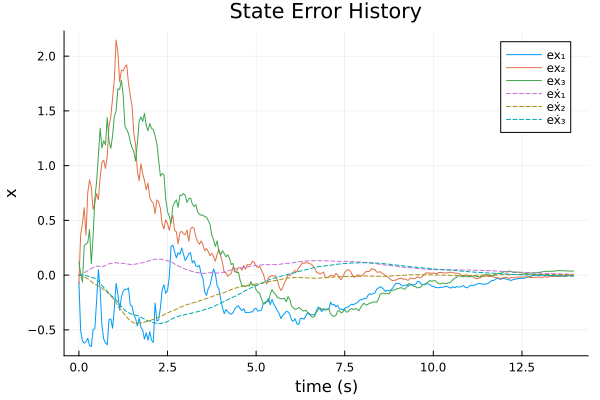

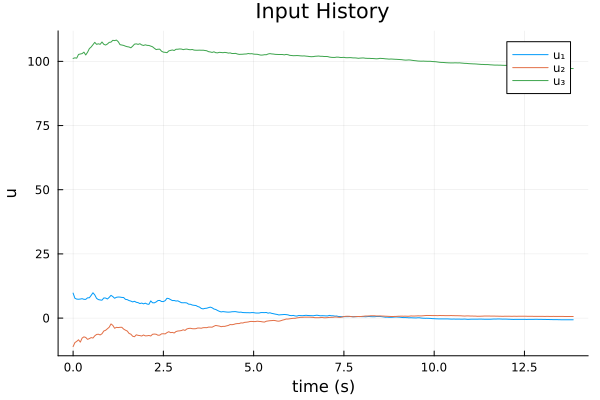

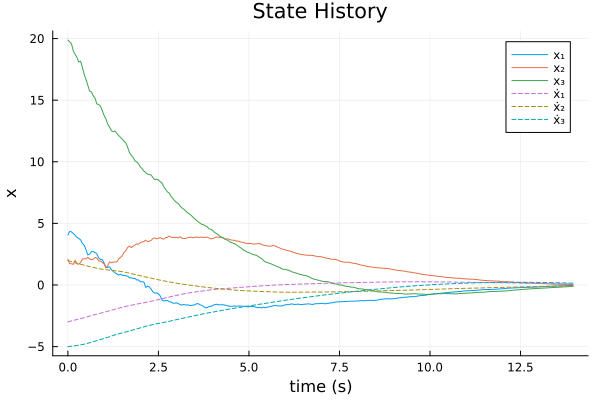

In [35]:
Xsim_m = mat_from_vec(Xhist[1:end-Nh])
Usim_m = mat_from_vec(Uhist[1:end-Nh-1])
e_sim_m = mat_from_vec(Xref[1:end-Nh]-Xhist[1:end-Nh])
@show traj_error = maximum(norm.(e_sim_m, Inf))
display(plot(t_vec[1:end-Nh],e_sim_m',label = ["ex₁" "ex₂" "ex₃" "eẋ₁" "eẋ₂" "eẋ₃"], 
             linestyle=[:solid :solid :solid :dash :dash :dash], 
             title = "State Error History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-Nh-2],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))
display(plot(t_vec[1:end-Nh],Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"], 
             linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))